In [152]:
import numpy as np
import matplotlib.pyplot as plt


In [291]:

def find_neigbours(size):
    assert size%2 == 0, "size must be even"
    # Only nearest neighbours
    a_neighbours = np.zeros((size,2),dtype=int)
    for i in range(size):
        a_neighbours[i,0] = (i+1)%size
        a_neighbours[i,1] = (i-1)%size

    is_done = False
    while not is_done:
        is_done = True
        b_neighbours = -np.ones((size,4),dtype=int)
        b_neighbours[:,0:2] = a_neighbours.copy()

        possible_nbs = np.arange(size)
        np.random.shuffle(possible_nbs)
        for i in range(size):
            all_except_self_and_nbs = possible_nbs[possible_nbs != i]
            for iii in range(4):
                all_except_self_and_nbs = all_except_self_and_nbs[all_except_self_and_nbs != b_neighbours[i,iii]]

            if len(all_except_self_and_nbs) == 0 :
                is_done = False
                break
            nb = np.random.choice(all_except_self_and_nbs)
            b_neighbours[i,2] = nb
            b_neighbours[nb,3] = i

            possible_nbs = possible_nbs[possible_nbs != nb]



    return a_neighbours, b_neighbours

find_neigbours(6)[0].T

array([[1, 2, 3, 4, 5, 0],
       [5, 0, 1, 2, 3, 4]])

In [320]:
J = 1.0


def order_param(lattice):
    return np.abs(np.sum(lattice)/len(lattice))

def E_full(lattice):
    return -J * np.sum(lattice * np.roll(lattice, 1, axis=0))

def E(site, lrest):
    return -J * site * lrest.sum()

def x_fun(site, lrest, T):
    return np.exp(2*E(site,lrest)*(1/T))

def flip(lattice, x):
    lattice[x] *= -1

def flip_maybe(lattice, neighbours, T):
    x = np.random.randint(0, neighbours.shape[0])
    
    indexs = neighbours[x]

    li = lattice[indexs]

    xf = x_fun(lattice[x], li, T)

    if np.random.random() < xf: # maybe .copy() or .ravel()
        flip(lattice, x)

def Jspace(n):
    return np.concatenate((np.linspace(0.1,1,n-1, endpoint=False),np.linspace(1,10,n, endpoint=True)))

def run(neighbours, T, n_runs):
    lattice = np.random.choice([-1,1], size = neighbours.shape[0])
    for i in range(n_runs):
        flip_maybe(lattice, neighbours, T)
    return lattice


def get_order_param(neighbours, T, n_runs, transient):
    lattice = np.random.choice([-1,1], size = neighbours.shape[0])

    order_params = np.zeros(n_runs-transient)
    for i in range(n_runs):
        flip_maybe(lattice, neighbours, T)
        if i > transient:
            order_params[i-transient] = order_param(lattice)
            
    return np.sum(order_params)/(n_runs-transient)

def sweep_T(size, n_runs):
    a_neighbours, b_neighbours = find_neigbours(size)
    order_params = np.zeros((2,20))
    for ii, nei in enumerate([a_neighbours, b_neighbours]):
        print(ii)
        for i, T in enumerate(np.linspace(0.1,10,20)):
            order_params[ii,i] = get_order_param(nei, T, n_runs+1000, transient=5000)
            # print(f"T: {T:.1f} <s>: {order_param(lattice):.3f}")
            # plt.imshow(np.repeat(lattice, 50,axis=0).reshape(size,50).T,cmap='gray',interpolation='none')
            # plt.show()
    
    return order_params



# sizes = [100, 500, 1000, 5000, 10000, 50000]
# for size in sizes:
#     n_runs = 10000
#     print(f"size: {size}")
#     binarysearch_4_T(size, n_runs)

plot the order parameter ⟨si⟩ vs. T

In [312]:
order_paramss = []
for size in [50, 200, 1000]:
    order_params = sweep_T(size, 100000)
    order_paramss.append(order_params)

0
1
0
1
0
1


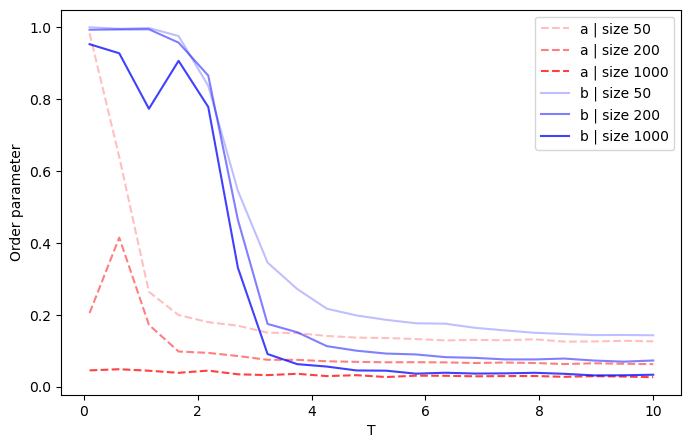

In [315]:
plt.figure(figsize=(8,5))

for i, (size, order_p) in enumerate(zip([50, 200, 1000], order_paramss)):
    plt.plot(np.linspace(0.1,10,20), order_p[0], label=f"a | size {size}", linestyle="--", color = "red", alpha=(i+1)/4)
    plt.plot(np.linspace(0.1,10,20), order_p[1], label=f"b | size {size}", linestyle="-", color = "blue", alpha=(i+1)/4)

plt.xlabel("T")
plt.ylabel("Order parameter")



#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [0,2,4,1,3,5]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 

In [360]:
def binarysearch_4_T(size, n_runs):
    max_t = 5
    min_t = 0.1
    T = (max_t+min_t)/2
    close = 2
    for i in range(50):
        T = (max_t+min_t)/2
        a_neighbours, b_neighbours = find_neigbours(size)
        lattice = run(b_neighbours, T, n_runs)

        op = np.abs(order_param(lattice))
        if op < 0.50:
            max_t = T
            min_t -= 0.1
        else:
            min_t = T
            max_t += 0.1

        if np.abs(op - 0.5) < 0.05:
            close -= 1
        if close == 0:
            break
            

    T = (max_t+min_t)/2
    print(f"Found T: {T:.3f} <s>: {op:.3f}")
    less, more = T-0.1, T+0.1
    # more_lattice = run(b_neighbours, more, n_runs)
    # less_lattice = run(b_neighbours, less, n_runs)
    # more_op = np.abs(order_param(more_lattice))
    # less_op = np.abs(order_param(less_lattice))
    # print("T-0.1 <s>: ", less_op)
    # print("T+0.1 <s>: ", more_op)
    # print("")
    return T, op

In [361]:
Ts = np.empty((3,7))

times = [10000,20000,20000,100000, 100000, 500000, 1000000]
for ii, N in enumerate((50, 100, 200, 300, 500, 1000, 2000)):
    for i in range(3):
        T, op = binarysearch_4_T(100, times[ii])
        Ts[i,ii] = T

Found T: 2.787 <s>: 0.500
Found T: 2.786 <s>: 0.480
Found T: 2.585 <s>: 0.460
Found T: 2.818 <s>: 0.500
Found T: 3.128 <s>: 0.500
Found T: 2.777 <s>: 0.460
Found T: 3.321 <s>: 0.460
Found T: 2.933 <s>: 0.520
Found T: 2.828 <s>: 0.540
Found T: 2.642 <s>: 0.540
Found T: 3.121 <s>: 0.500
Found T: 3.122 <s>: 0.520
Found T: 2.855 <s>: 0.500
Found T: 2.979 <s>: 0.540
Found T: 2.766 <s>: 0.520
Found T: 2.687 <s>: 0.460
Found T: 2.925 <s>: 0.540
Found T: 2.578 <s>: 0.460
Found T: 3.049 <s>: 0.500
Found T: 2.687 <s>: 0.520
Found T: 2.652 <s>: 0.500


Text(0, 0.5, 'T')

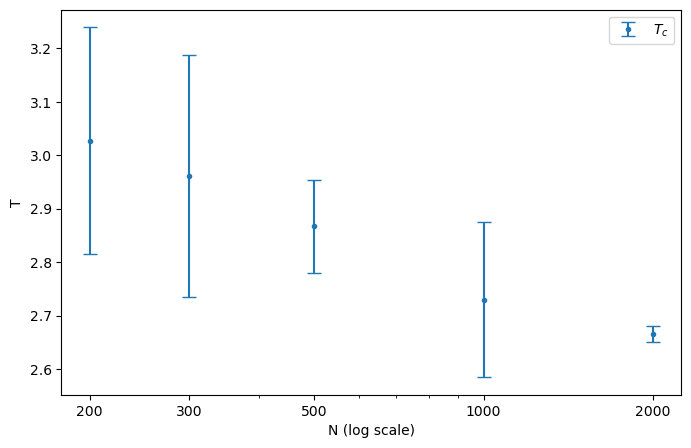

In [410]:
plt.figure(figsize=(8,5))

plt.errorbar([200, 300, 500, 1000, 2000], Ts.mean(axis=0)[2:], yerr=Ts.std(axis=0)[2:], label="$T_c$", fmt = ".", capsize=5)
plt.xscale("log")
plt.xlabel("N (log scale)")
plt.legend()
plt.xticks([200, 300, 500, 1000, 2000], [200, 300, 500, 1000, 2000])
plt.ylabel("T")

2.6598879436615483


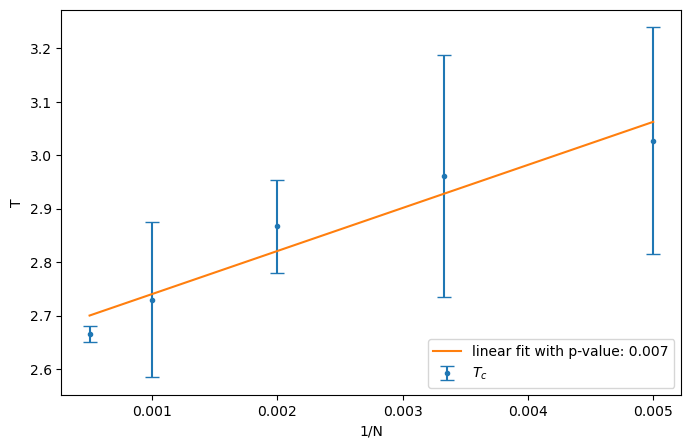

In [431]:

Ns = np.array([200, 300, 500, 1000, 2000])
inv_Ns = 1/Ns


plt.figure(figsize=(8,5))
plt.errorbar(inv_Ns, Ts.mean(axis=0)[2:], yerr=Ts.std(axis=0)[2:], label="$T_c$", fmt = ".", capsize=5)

# make linear fit
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(inv_Ns, Ts.mean(axis=0)[2:])

plt.plot(inv_Ns, intercept + slope*np.array(inv_Ns), label=f"linear fit with p-value: {p_value:.3f}")

# plt.xlim(190,2100)

print(intercept)
plt.legend(loc = "lower right")
plt.ylabel("T")
plt.xlabel("1/N")
# plt.xscale("log")
plt.show()

Domain wall stuff

In [432]:
ss_corr = lambda T, L: np.exp(-L*np.log(1/np.tanh(1/T)))

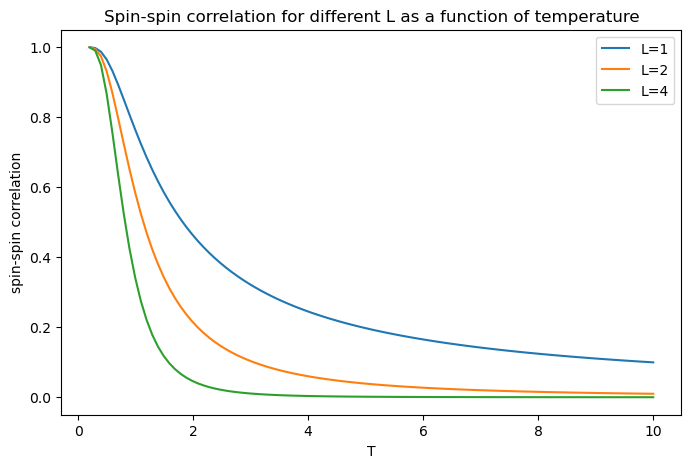

In [444]:
ts = np.linspace(0.2,10,100)

plt.figure(figsize=(8,5))
plt.plot(ts, ss_corr(ts, 1), label="L=1")
plt.plot(ts, ss_corr(ts, 2), label="L=2")
plt.plot(ts, ss_corr(ts, 4), label="L=4")
plt.legend()
plt.xlabel("T")
plt.ylabel("spin-spin correlation")

plt.title("Spin-spin correlation for different L as a function of temperature")
plt.show()